In [17]:
import json
import math
import base64
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from celluloid import Camera
from IPython.display import Image
from IPython.display import HTML

BAYES_QUARTILE_OPT = 0.25
RATES = [1,2,3,4,5]
index = 0
asinToIndex = {}
scoreMatrix = []
booksAsin = []
bookReviewYearly = {}
yearlyReviewCount = {}
minYear = 3000
maxYear = 0
chunks = pd.read_json(
    '../Dataset/Books.json', lines=True, chunksize=500000, 
    typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
)

nbChunks = 0 # <= 0 to load all chunks, positive integer to load specific number of chunks
for chunk in chunks:
    for _, item in chunk.iterrows():
        asin = item["asin"]
        rate = item["overall"]
        reviewTime = item["unixReviewTime"]
        reviewDate = datetime.utcfromtimestamp(reviewTime)
        bookReviewElement = bookReviewYearly.setdefault(reviewDate.year, {}).setdefault(reviewDate.month, {}).setdefault(asin, [0,0,0,0,0])
        bookReviewYearly[reviewDate.year][reviewDate.month][asin][rate-1] += 1
        yearlyReviewCount.setdefault(reviewDate.year, 0)
        yearlyReviewCount[reviewDate.year] += 1
        maxYear = max(maxYear, reviewDate.year)
        minYear = min(minYear, reviewDate.year)

        if (asin not in asinToIndex):
            scoreMatrix.append([0,0,0,0,0])
            booksAsin.append(asin)
            asinToIndex[asin] = index
            index += 1

        row = asinToIndex[asin]
        scoreMatrix[row][rate-1] += 1
    nbChunks -= 1
    if (nbChunks == 0):
        break

scoreMatrix = np.array(scoreMatrix)
pdScoreMat = pd.DataFrame(
    data=scoreMatrix,
    index=booksAsin,
    columns=[f"{i} ⭐" for i in RATES]
)
pdScoreMat

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5
...,...,...,...,...,...
B00LZFHL7Y,0,0,1,2,13
B00LZKMXBI,0,1,4,14,141
B00M029T4O,0,0,0,1,12
B00M0RE7CS,0,0,0,1,29


In [18]:
def getAvgRating(scoreMatrix):
    nbRating = np.sum(scoreMatrix, axis=1)
    avgRatings = (np.average(scoreMatrix, axis=1, weights=RATES) * np.sum(RATES)) / nbRating
    return nbRating, avgRatings

def getRatingsStd(scoreMatrix):
    stdRatings = np.std(scoreMatrix, axis=0)
    return stdRatings

def getMinMaxRating(scoreMatrix):
    maxRating = np.max(scoreMatrix, axis=0)
    minRating = np.min(scoreMatrix, axis=0)
    return minRating, maxRating

def getRatingsQuantile(scoreMatrix):
    ratingQ1 = np.quantile(scoreMatrix, 0.25, axis=0)
    ratingQ2 = np.quantile(scoreMatrix, 0.5, axis=0)
    ratingQ3 = np.quantile(scoreMatrix, 0.75, axis=0)
    return ratingQ1, ratingQ2, ratingQ3

def getTop3Bottom3AndQ1Books(scoreMatrix, avgRatings):
    # Books sorted by average score
    sortedIndicies = np.flip(np.argsort(avgRatings)) # Ascending order
    top3Books = pd.DataFrame(
        data=[avgRatings[i] for i in sortedIndicies[0:3]],
        index=[booksAsin[i] for i in sortedIndicies[0:3]],
        columns=[f"Average Score"]
    )
    bottom3Books = pd.DataFrame(
        data=[avgRatings[i] for i in sortedIndicies[-1:-4:-1]],
        index=[booksAsin[i] for i in sortedIndicies[-1:-4:-1]],
        columns=[f"Average Score"]
    )
    q1BestBooksAsins = pd.DataFrame(
        data=[avgRatings[i] for i in sortedIndicies[0:math.ceil(len(sortedIndicies) * 0.25)]],
        index=[booksAsin[i] for i in sortedIndicies[0:math.ceil(len(sortedIndicies) * 0.25)]],
        columns=[f"Average Score"]
    )
    return top3Books, bottom3Books, q1BestBooksAsins

def compareTwoBooks(asin1, asin2, avgRatings):
    idx1 = asinToIndex[asin1]
    idx2 = asinToIndex[asin2]
    diff = avgRatings[idx1] - avgRatings[idx2]
    if (diff > 0):
        return f"{asin1} is rated better than {asin2}"
    elif (diff < 0):
        return f"{asin2} is rated better than {asin1}"
    return f"{asin1} and {asin2} have the same ratings"

nbRating, avgRatings = getAvgRating(scoreMatrix)
stdRatings = getRatingsStd(scoreMatrix)
minRating, maxRating = getMinMaxRating(scoreMatrix)
ratingQ1, ratingQ2, ratingQ3 = getRatingsQuantile(scoreMatrix)
top3Books, bottom3Books, q1BestBooksAsins = getTop3Bottom3AndQ1Books(scoreMatrix, avgRatings)

avgAndNbRating = pd.DataFrame(
    data=np.column_stack((nbRating, avgRatings)),
    index=booksAsin,
    columns=["Nb rating", "Average Rating"]
)
perStarRatingStats = pd.DataFrame(
    data=np.column_stack((stdRatings, minRating, maxRating, ratingQ1, ratingQ2, ratingQ3)),
    index=[f"{i} ⭐" for i in RATES],
    columns=["STD", "Min Rating Count", "Max Rating Count", "Rating Q1", "Rating Q2", "Rating Q3"]
)

print("Nb & Average rating :")
display(avgAndNbRating)
print(f"Per rating star stats : ")
display(perStarRatingStats)
print(f"Top 3 books :")
display(top3Books)
print(f"Bottom 3 books :")
display(bottom3Books)
print(f"First Quantile of Best books :")
display(q1BestBooksAsins)

Nb & Average rating :


,Nb rating,Average Rating
000100039X,206.0,4.674757
0001055178,18.0,3.555556
0001473123,16.0,4.625000
0001473727,7.0,5.000000
0001473905,6.0,4.666667
...,...,...
B00LZFHL7Y,16.0,4.750000
B00LZKMXBI,160.0,4.843750
B00M029T4O,13.0,4.923077
B00M0RE7CS,30.0,4.966667


Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,4.809402,0.0,1565.0,0.0,0.0,1.0
2 ⭐,4.139151,0.0,640.0,0.0,0.0,1.0
3 ⭐,7.780350,0.0,1209.0,0.0,1.0,3.0
4 ⭐,16.193180,0.0,2065.0,1.0,3.0,6.0
5 ⭐,39.736187,0.0,4839.0,4.0,6.0,12.0


Top 3 books :


,Average Score
B00J7X9BKG,5.0
B00KMXDQ1A,5.0
0835608794,5.0


Bottom 3 books :


,Average Score
1419643797,1.0
B008L2KL08,1.0
B008KXP65S,1.0


First Quantile of Best books :


,Average Score
B00J7X9BKG,5.000
B00KMXDQ1A,5.000
0835608794,5.000
B008AD15P8,5.000
1481152092,5.000
...,...
1412772117,4.625
0711218005,4.625
B008LI171E,4.625
0989019608,4.625


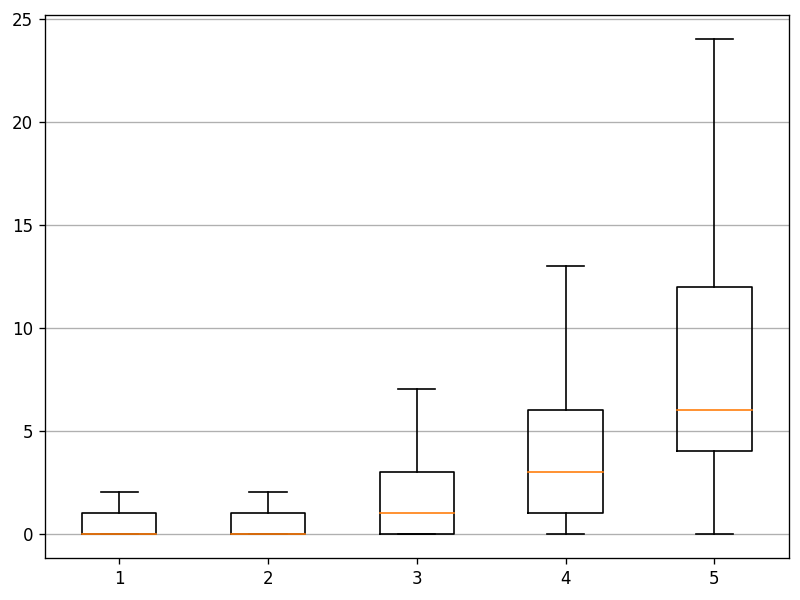

In [19]:
plt.figure(figsize=(8, 6), dpi=120)
plt.grid(which='major', axis='y', zorder=0)
plt.boxplot(scoreMatrix, showfliers=False, zorder=5)
plt.show()

In [20]:
# Calculate better average metric to classify books
def bayesAverage(avgRatings, nbRating, C, m):
    bayesAvgRatings = (nbRating * avgRatings + m * C) / (nbRating + C)
    return bayesAvgRatings

confidenceNumber = np.quantile(nbRating, BAYES_QUARTILE_OPT)
arithAverage = np.mean(avgRatings)
print(f"Confidence number (C) = {confidenceNumber}, Arthimetic average of all rating (m) = {arithAverage}")
bayesAvgRatings = bayesAverage(avgRatings, nbRating, confidenceNumber, arithAverage)
top3Books, bottom3Books, q1BestBooksAsins = getTop3Bottom3AndQ1Books(scoreMatrix, avgRatings)
bayesAvgRatingPd = pd.DataFrame(
    data=np.column_stack((nbRating, avgRatings, bayesAvgRatings)),
    index=booksAsin,
    columns=["Nb rating", "Average Rating", "Bayes Averagte Rating"]
)

print("Bayes average rating :")
display(bayesAvgRatingPd)
print(f"Top 3 books (Bayes Avg) :")
display(top3Books)
print(f"Bottom 3 books (Bayes Avg) :")
display(bottom3Books)
print(f"First Quantile of Best books (Bayes Avg) :")
display(q1BestBooksAsins)

Confidence number (C) = 6.0, Arthimetic average of all rating (m) = 4.261260090435146
Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,206.0,4.674757,4.663055
0001055178,18.0,3.555556,3.731982
0001473123,16.0,4.625000,4.525798
0001473727,7.0,5.000000,4.659043
0001473905,6.0,4.666667,4.463963
...,...,...,...
B00LZFHL7Y,16.0,4.750000,4.616707
B00LZKMXBI,160.0,4.843750,4.822696
B00M029T4O,13.0,4.923077,4.714082
B00M0RE7CS,30.0,4.966667,4.849099


Top 3 books (Bayes Avg) :


,Average Score
B00J7X9BKG,5.0
B00KMXDQ1A,5.0
0835608794,5.0


Bottom 3 books (Bayes Avg) :


,Average Score
1419643797,1.0
B008L2KL08,1.0
B008KXP65S,1.0


First Quantile of Best books (Bayes Avg) :


,Average Score
B00J7X9BKG,5.000
B00KMXDQ1A,5.000
0835608794,5.000
B008AD15P8,5.000
1481152092,5.000
...,...
1412772117,4.625
0711218005,4.625
B008LI171E,4.625
0989019608,4.625


Eigenvalues : [3.8484473  0.73351121 0.27006033 0.09641518 0.05157957]
Eigenvector : [[ 0.38290409  0.69853594  0.49585562 -0.34299185 -0.04376962]
 [ 0.46836074  0.32523524 -0.32791971  0.66635992  0.35113157]
 [ 0.48530595 -0.05635775 -0.48116346 -0.17856159 -0.70561989]
 [ 0.46901486 -0.37564442 -0.14499092 -0.52563855  0.58446392]
 [ 0.42252321 -0.51184436  0.62773818  0.36075049 -0.18786522]]
Seperation percentages of PCs : [76.96873676934189, 14.670184329181367, 5.401191891302892, 1.9282983547386168, 1.0315886554352336]


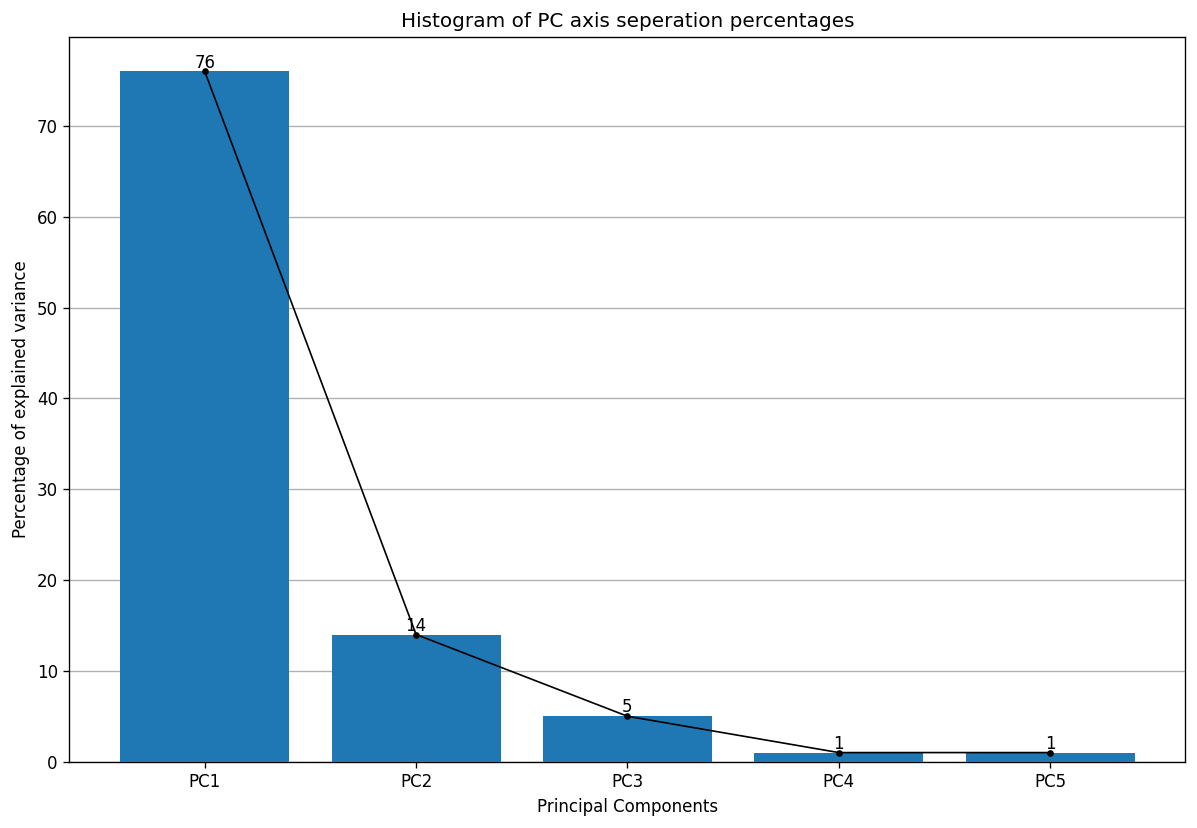

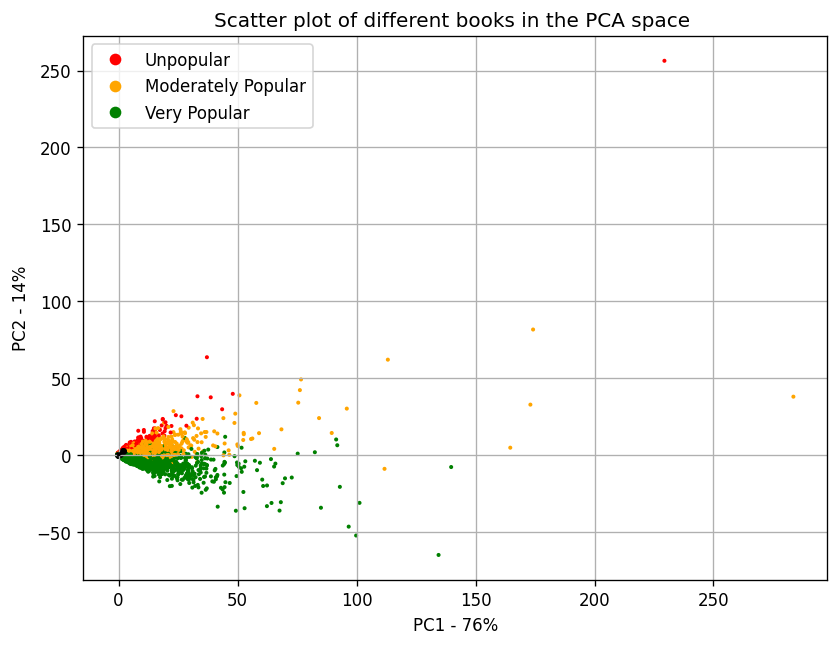

Classes count : {'Unpopular': 1321, 'Moderately Popular': 68143, 'Very Popular': 298518}


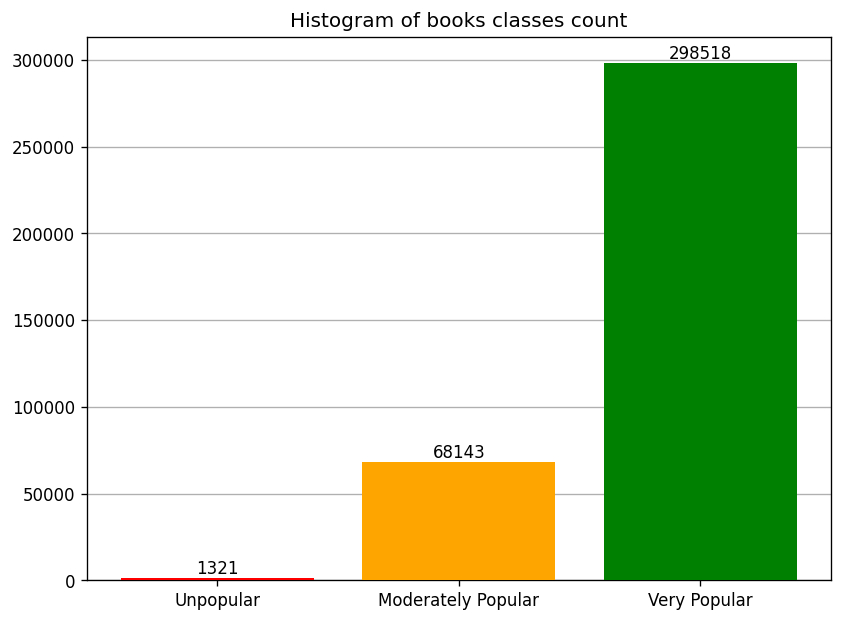

In [21]:
classifierFunc = np.vectorize(lambda score: 0 if (score < 3) else 2 if (score > 4) else 1)
classes = ['Unpopular', 'Moderately Popular', 'Very Popular']
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)

def normalizeData(scoreMatrix):
    # Normalise score matrix
    normalizedScoreMatrix = (scoreMatrix - np.mean(scoreMatrix, axis = 0)) / np.std(scoreMatrix, axis = 0)
    return normalizedScoreMatrix

def PCA(scoreMatrix):
    # https://builtin.com/data-science/step-step-explanation-principal-component-analysis
    # Normalise score matrix
    normalizedScoreMatrix = normalizeData(scoreMatrix)
    # Calculate covariance
    scoreMatrixCov = np.cov(normalizedScoreMatrix, rowvar = False) # rowvar allows us to transpose data!
    # Calculate eigen-values and eigen-vectors
    eigenValues, eigenVectors = np.linalg.eig(scoreMatrixCov)
    # Variance of each Principal Component (PC)
    idx = np.argsort(eigenValues)[::-1]
    evecs = eigenVectors[:,idx]
    evals = eigenValues[idx]
    evalsVar = [ (eval/sum(evals)) * 100 for eval in evals ]
    #  PCA calculation
    projectionMatrix = np.transpose(np.transpose(evecs)[:][:2])
    projectedPcaMatrix = np.dot(normalizedScoreMatrix, projectionMatrix)
    return eigenValues, eigenVectors, evalsVar, projectionMatrix, projectedPcaMatrix

def plotPCAHelper(projectedPcaMatrix, bayesAvgRatings, extraText="", plotCenters=True):
    x, y = np.transpose(projectedPcaMatrix)
    booksClasses = classifierFunc(bayesAvgRatings)
    scatter = plt.scatter(x, y, c=booksClasses, cmap=colors, s=2)
    plt.legend(handles=scatter.legend_elements(num=3)[0], labels=classes)
    plt.title(f"Scatter plot of different books in the PCA space {extraText}")
    if (plotCenters):
        clusterCentersX = [np.mean(x[booksClasses == i]) for i in range(0,3)]
        clusterCentersY = [np.mean(y[booksClasses == i]) for i in range(0,3)]
        clusterCentersX.append(clusterCentersX[0])
        clusterCentersY.append(clusterCentersY[0])
        plt.plot(clusterCentersX, clusterCentersY, zorder=2, c="black")
        plt.scatter(clusterCentersX, clusterCentersY, c="black", s=10)
    return x, y, booksClasses

def plotPCA(projectedPcaMatrix, bayesAvgRatings, extraText="", show=True, plotCenters=True):
    if (show):
        plt.figure(figsize=(8, 6), dpi=120)
    plt.xlabel(f"PC1 - {math.floor(evalsVar[0])}%")
    plt.ylabel(f"PC2 - {math.floor(evalsVar[1])}%")
    plt.grid()
    x, y, booksClasses = plotPCAHelper(projectedPcaMatrix, bayesAvgRatings, extraText, plotCenters)
    if (show):
        plt.show()
    return booksClasses

eigenValues, eigenVectors, evalsVar, projectionMatrix, projectedPcaMatrix = PCA(scoreMatrix)
print(f"Eigenvalues : {eigenValues}")
print(f"Eigenvector : {eigenVectors}")
print(f"Seperation percentages of PCs : {evalsVar}")

plt.figure(figsize=(12, 8), dpi=120)
plt.xlabel(f"Principal Components")
plt.ylabel(f"Percentage of explained variance")
plt.grid(which='major', axis='y', zorder=0)
truncedPCPercentages = np.array(evalsVar).astype(int)
pcAxis = np.arange(len(evalsVar))
plt.plot(truncedPCPercentages, zorder=10, c="black", marker='o',linewidth=1,markersize=3)
bars = plt.bar(pcAxis, truncedPCPercentages, zorder=5) 
plt.bar_label(bars)
plt.xticks(pcAxis, [f"PC{i+1}" for i in range(len(evalsVar))])
plt.title(f"Histogram of PC axis seperation percentages") 
plt.show()

booksClasses = plotPCA(projectedPcaMatrix, bayesAvgRatings)
plt.figure(figsize=(8, 6), dpi=120)
plt.grid(which='major', axis='y', zorder=0)
rateClasses, classFrequency = np.unique(booksClasses, return_counts=True)
print(f"Classes count : {dict(zip([classes[i] for i in rateClasses], classFrequency))}")
bars = plt.bar([classes[i] for i in rateClasses], height=classFrequency, 
    color=[colorsList[i] for i in rateClasses], align="center", zorder=5) 
plt.bar_label(bars)
plt.title("Histogram of books classes count") 
plt.show()

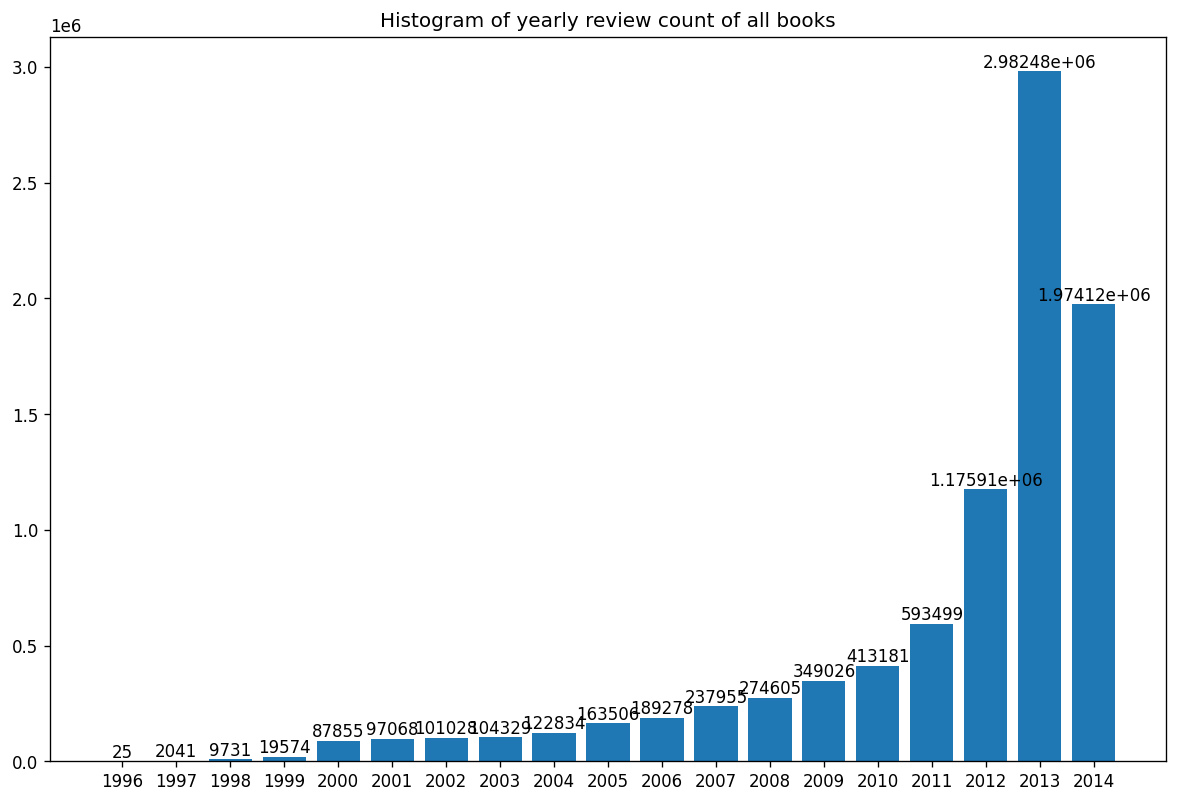

Yearly review count : {1996: 25, 1997: 2041, 1998: 9731, 1999: 19574, 2000: 87855, 2001: 97068, 2002: 101028, 2003: 104329, 2004: 122834, 2005: 163506, 2006: 189278, 2007: 237955, 2008: 274605, 2009: 349026, 2010: 413181, 2011: 593499, 2012: 1175910, 2013: 2982481, 2014: 1974115}


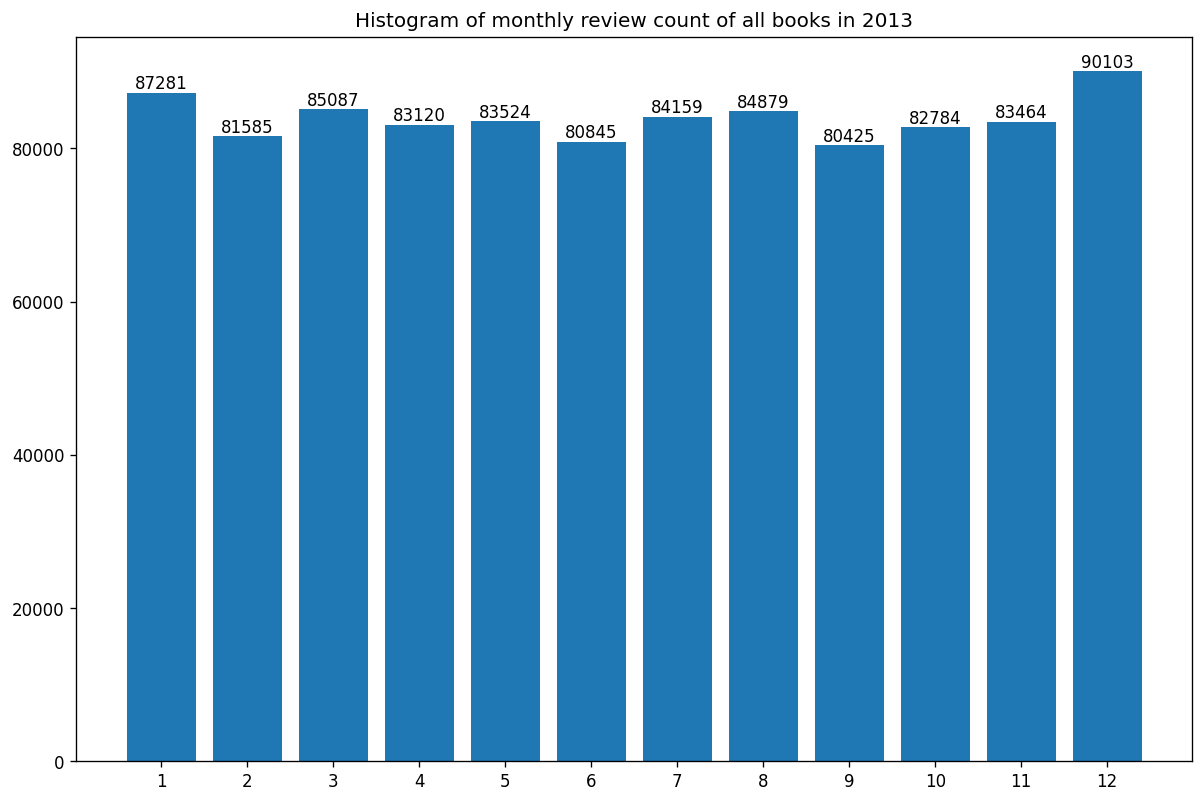

Monthly review count for 2013 : {1: 87281, 2: 81585, 3: 85087, 4: 83120, 5: 83524, 6: 80845, 7: 84159, 8: 84879, 9: 80425, 10: 82784, 11: 83464, 12: 90103}


In [22]:
def getYearWithMostReviews(yearlyReviewCount, minYear, maxYear):
    maxReviews = 0
    resYear = minYear
    for y in range(minYear, maxYear+1):
        if (yearlyReviewCount[y] > maxReviews):
            maxReviews = yearlyReviewCount[y]
            resYear = y
    return resYear

yearToStudy = getYearWithMostReviews(yearlyReviewCount, minYear, maxYear)
yearToStudyMonthlyReviewCount = [ len(bookReviewYearly[yearToStudy][m].values()) for m in range(1,13) ]

plt.figure(figsize=(12, 8), dpi=120)
yearsSorted = sorted(list(yearlyReviewCount.keys()))
yearXAxis = np.arange(len(yearsSorted))
bars = plt.bar(yearXAxis, [yearlyReviewCount[k] for k in yearsSorted]) 
plt.bar_label(bars)
plt.xticks(yearXAxis, yearsSorted)
plt.title("Histogram of yearly review count of all books") 
plt.show()
yearReviewCountDict = {k: yearlyReviewCount[k] for k in yearsSorted}
print(f"Yearly review count : {yearReviewCountDict}")

plt.figure(figsize=(12, 8), dpi=120)
monthsSorted = np.arange(1, 13)
bars = plt.bar(monthsSorted, [yearToStudyMonthlyReviewCount[k-1] for k in monthsSorted])
plt.bar_label(bars)
plt.xticks(monthsSorted, monthsSorted)
plt.title(f"Histogram of monthly review count of all books in {yearToStudy}") 
plt.show()

monthlyReviewCountDict = {m: yearToStudyMonthlyReviewCount[m-1] for m in range(1,13)}
print(f"Monthly review count for {yearToStudy} : {monthlyReviewCountDict}")

Month 1/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.521191,0.0,59.0,0.0,0.0,0.0
2 ⭐,0.570486,0.0,45.0,0.0,0.0,0.0
3 ⭐,1.163265,0.0,110.0,0.0,0.0,0.0
4 ⭐,2.438507,0.0,178.0,0.0,0.0,1.0
5 ⭐,6.387699,0.0,933.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
0525952446,4.972519
052595435X,4.965976
0312335873,4.962395


	Bottom 3 books (Bayes Avg) :


,Average Score
0261669966,1.547583
0545086159,1.657100
052180079X,1.657100


	First Quantile of Best books (Bayes Avg) :


,Average Score
0525952446,4.972519
052595435X,4.965976
0312335873,4.962395
0520071182,4.960305
0352347171,4.957970
...,...
0312585934,4.642749
0312583524,4.642749
0316106224,4.642749
0316106232,4.642749


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,2.0,5.00,4.761833
0001473123,1.0,5.00,4.642749
0001712772,1.0,5.00,4.642749
0002007770,136.0,4.50,4.498434
0002051850,4.0,4.25,4.257100
...,...,...,...
B00DO0OPUY,1.0,5.00,4.642749
B00E67DT7O,1.0,4.00,4.142749
B00FPXBJZM,1.0,4.00,4.142749
B00GNK1XZM,1.0,5.00,4.642749


Month 2/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.481951,0.0,51.0,0.0,0.0,0.0
2 ⭐,0.502653,0.0,46.0,0.0,0.0,0.0
3 ⭐,0.973464,0.0,82.0,0.0,0.0,0.0
4 ⭐,2.086602,0.0,144.0,0.0,0.0,1.0
5 ⭐,4.959428,0.0,440.0,0.0,1.0,1.0


	Top 3 books (Bayes Avg) :


,Average Score
0373874383,4.967695
0470640049,4.962595
0451228030,4.960517


	Bottom 3 books (Bayes Avg) :


,Average Score
0151004161,1.187078
0397315368,1.657860
0345508998,1.714883


	First Quantile of Best books (Bayes Avg) :


,Average Score
0373874383,4.967695
0470640049,4.962595
0451228030,4.960517
0312860390,4.960517
0470919973,4.958194
...,...
0316405345,4.644649
0470620749,4.644649
007174648X,4.644649
0071461647,4.644649


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,4.0,3.75,3.857860
0001473123,2.0,5.00,4.763100
0001473727,1.0,5.00,4.644649
0001473905,1.0,5.00,4.644649
0002006715,1.0,5.00,4.644649
...,...,...,...
B00BMRTDPS,1.0,5.00,4.644649
B00BMUQS8K,1.0,5.00,4.644649
B00C74OY1S,1.0,3.00,3.644649
B00D9HDI5K,1.0,5.00,4.644649


Month 3/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.417786,0.0,33.0,0.0,0.0,0.0
2 ⭐,0.508742,0.0,37.0,0.0,0.0,0.0
3 ⭐,1.016229,0.0,77.0,0.0,0.0,0.0
4 ⭐,2.184520,0.0,158.0,0.0,0.0,1.0
5 ⭐,5.583378,0.0,497.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
009193558X,4.976188
0515151556,4.976188
0500251789,4.972525


	Bottom 3 books (Bayes Avg) :


,Average Score
0446578703,1.657129
0373754108,1.690470
0486491374,1.714274


	First Quantile of Best books (Bayes Avg) :


,Average Score
009193558X,4.976188
0515151556,4.976188
0500251789,4.972525
0385334249,4.971426
0471197130,4.971426
...,...
0373226772,4.642822
0373226985,4.642822
030744645X,4.642822
0307446298,4.642822


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,2.0,5.0,4.761881
0002005395,1.0,5.0,4.642822
0002007770,40.0,4.6,4.592333
0002051850,5.0,4.0,4.047607
0002113570,1.0,5.0,4.642822
...,...,...,...
B00C4HPAKW,1.0,5.0,4.642822
B00C74R66I,1.0,3.0,3.642822
B00C74WXBG,1.0,4.0,4.142822
B00ECCVDKS,1.0,4.0,4.142822


Month 4/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.570329,0.0,101.0,0.0,0.0,0.0
2 ⭐,0.542605,0.0,62.0,0.0,0.0,0.0
3 ⭐,1.041545,0.0,105.0,0.0,0.0,0.0
4 ⭐,2.234684,0.0,166.0,0.0,0.0,1.0
5 ⭐,5.858436,0.0,636.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
0374281041,4.970909
0471449733,4.969697
0448454041,4.968380


	Bottom 3 books (Bayes Avg) :


,Average Score
0307341992,1.241034
0345510798,1.327273
0345510836,1.409092


	First Quantile of Best books (Bayes Avg) :


,Average Score
0374281041,4.970909
0471449733,4.969697
0448454041,4.968380
0451231287,4.968380
0471794473,4.966942
...,...
0060665491,4.636366
0060664517,4.636366
0060663723,4.636366
0060725540,4.636366


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,2.0,5.000000,4.757578
0001712772,1.0,5.000000,4.636366
0001714538,1.0,1.000000,2.636366
0002007770,30.0,4.533333,4.524927
0002051850,2.0,5.000000,4.757578
...,...,...,...
B00DPWRQIO,1.0,5.000000,4.636366
B00DUFFM1Y,1.0,5.000000,4.636366
B00EK3MVL4,1.0,4.000000,4.136366
B00G4LJE74,1.0,3.000000,3.636366


Month 5/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.903743,0.0,233.0,0.0,0.0,0.0
2 ⭐,0.623488,0.0,109.0,0.0,0.0,0.0
3 ⭐,1.035651,0.0,100.0,0.0,0.0,0.0
4 ⭐,2.109776,0.0,131.0,0.0,0.0,1.0
5 ⭐,4.995128,0.0,337.0,0.0,1.0,1.0


	Top 3 books (Bayes Avg) :


,Average Score
0060841761,4.987935
0446947970,4.975870
0446533629,4.967096


	Bottom 3 books (Bayes Avg) :


,Average Score
0312352778,1.352379
034550254X,1.546019
0446693022,1.655223


	First Quantile of Best books (Bayes Avg) :


,Average Score
0060841761,4.987935
0446947970,4.975870
0446533629,4.967096
0316033782,4.967096
0441842925,4.965529
...,...
0373297610,4.638056
0143035347,4.638056
037329767X,4.638056
0143035339,4.638056


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,3.0,4.666667,4.569028
0001473123,1.0,5.000000,4.638056
0001712772,1.0,5.000000,4.638056
0002007770,32.0,4.625000,4.614428
0002051850,6.0,4.833333,4.753730
...,...,...,...
B00E67DT7O,1.0,4.000000,4.138056
B00ECCVDKS,1.0,5.000000,4.638056
B00G8JY6AW,1.0,4.000000,4.138056
B00HFNGAX6,1.0,5.000000,4.638056


Month 6/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.980166,0.0,247.0,0.0,0.0,0.0
2 ⭐,0.828275,0.0,170.0,0.0,0.0,0.0
3 ⭐,1.377388,0.0,202.0,0.0,0.0,0.0
4 ⭐,2.404558,0.0,264.0,0.0,0.0,1.0
5 ⭐,5.744955,0.0,731.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
006081618X,4.989673
0399158715,4.961953
0373769288,4.961953


	Bottom 3 books (Bayes Avg) :


,Average Score
0373771274,1.468159
0373775792,1.490309
0393967972,1.655422


	First Quantile of Best books (Bayes Avg) :


,Average Score
006081618X,4.989673
0399158715,4.961953
0373769288,4.961953
0373797567,4.959840
0470504544,4.957477
...,...
0061243876,4.638556
0061243582,4.638556
0061243531,4.638556
0061246263,4.638556


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,3.0,5.000000,4.819278
0001473123,2.0,4.500000,4.425704
000171287X,1.0,5.000000,4.638556
0002007770,43.0,4.372093,4.369934
0002051850,1.0,5.000000,4.638556
...,...,...,...
B00EJXIY2A,1.0,1.000000,2.638556
B00G4LJE74,1.0,4.000000,4.138556
B00ILE136W,1.0,5.000000,4.638556
B00IZ542LU,1.0,5.000000,4.638556


Month 7/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.461693,0.0,45.0,0.0,0.0,0.0
2 ⭐,0.544987,0.0,69.0,0.0,0.0,0.0
3 ⭐,1.139590,0.0,160.0,0.0,0.0,0.0
4 ⭐,2.233845,0.0,204.0,0.0,0.0,1.0
5 ⭐,5.858779,0.0,576.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
0060828862,4.992191
0486265420,4.977582
048645178X,4.968425


	Bottom 3 books (Bayes Avg) :


,Average Score
0060825464,1.818445
0345530667,1.818445
0373767277,1.896254


	First Quantile of Best books (Bayes Avg) :


,Average Score
0060828862,4.992191
0486265420,4.977582
048645178X,4.968425
0373893035,4.961778
0486444848,4.959654
...,...
0201844532,4.636890
0316204366,4.636890
0142001910,4.636890
0201824701,4.636890


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,5.0,4.800000,4.712297
0001473123,1.0,4.000000,4.136890
000171287X,1.0,4.000000,4.136890
0002007770,34.0,4.529412,4.522108
0002051850,2.0,3.000000,3.424593
...,...,...,...
B00E9DQLBG,1.0,5.000000,4.636890
B00E9HG86U,5.0,5.000000,4.878963
B00E9HGID8,1.0,3.000000,3.636890
B00E9JBEDU,2.0,4.000000,4.091260


Month 8/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.479205,0.0,57.0,0.0,0.0,0.0
2 ⭐,0.584950,0.0,77.0,0.0,0.0,0.0
3 ⭐,1.197735,0.0,158.0,0.0,0.0,0.0
4 ⭐,2.395049,0.0,335.0,0.0,0.0,1.0
5 ⭐,5.297642,0.0,387.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
0505526190,4.982032
0495906336,4.975216
0312860501,4.973381


	Bottom 3 books (Bayes Avg) :


,Average Score
0446533645,1.611611
0312494351,1.656255
0321722132,1.713546


	First Quantile of Best books (Bayes Avg) :


,Average Score
0505526190,4.982032
0495906336,4.975216
0312860501,4.973381
0486433315,4.962172
0380788632,4.962172
...,...
0345428560,4.640637
0193532271,4.640637
0345435923,4.640637
0192880330,4.640637


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,3.0,5.00000,4.820319
0001712772,1.0,5.00000,4.640637
000171287X,1.0,5.00000,4.640637
0001714538,1.0,4.00000,4.140637
0002007770,27.0,4.62963,4.617188
...,...,...,...
B00EWT1M34,4.0,4.50000,4.456255
B00I45AE1I,1.0,4.00000,4.140637
B00I7DYBD4,1.0,4.00000,4.140637
B00I8YCVKW,1.0,1.00000,2.640637


Month 9/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.441370,0.0,31.0,0.0,0.0,0.0
2 ⭐,0.505068,0.0,33.0,0.0,0.0,0.0
3 ⭐,1.022983,0.0,91.0,0.0,0.0,0.0
4 ⭐,2.164007,0.0,190.0,0.0,0.0,1.0
5 ⭐,5.322108,0.0,453.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
0470411678,4.983213
0451456629,4.974220
0465084664,4.972237


	Bottom 3 books (Bayes Avg) :


,Average Score
0316112992,1.159944
0385468776,1.218544
0340964367,1.662726


	First Quantile of Best books (Bayes Avg) :


,Average Score
0470411678,4.983213
0451456629,4.974220
0465084664,4.972237
0374302995,4.969924
0465081401,4.965627
...,...
0226644294,4.639083
0226675793,4.639083
0226616746,4.639083
0226616673,4.639083


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,3.0,5.000000,4.819541
0001473123,1.0,5.000000,4.639083
0002007770,34.0,4.147059,4.150805
0002051850,2.0,5.000000,4.759389
0002113570,1.0,5.000000,4.639083
...,...,...,...
B00FJD14TO,1.0,5.000000,4.639083
B00FJE96FM,1.0,5.000000,4.639083
B00FJH5IRO,1.0,5.000000,4.639083
B00FJLKZFU,1.0,5.000000,4.639083


Month 10/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.654146,0.0,139.0,0.0,0.0,0.0
2 ⭐,0.601942,0.0,98.0,0.0,0.0,0.0
3 ⭐,0.997043,0.0,90.0,0.0,0.0,0.0
4 ⭐,2.106394,0.0,151.0,0.0,0.0,1.0
5 ⭐,5.684297,0.0,554.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
0373829272,4.985545
0192833510,4.982292
0345278372,4.977151


	Bottom 3 books (Bayes Avg) :


,Average Score
0312939744,1.219446
0470438991,1.548615
0345537009,1.658338


	First Quantile of Best books (Bayes Avg) :


,Average Score
0373829272,4.985545
0192833510,4.982292
0345278372,4.977151
0465023711,4.975575
0486206106,4.975575
...,...
0312313438,4.645844
0312959761,4.645844
0312959788,4.645844
0312959826,4.645844


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,4.0,5.00000,4.858338
0001473123,1.0,5.00000,4.645844
000171287X,1.0,5.00000,4.645844
0002006715,1.0,5.00000,4.645844
0002007770,21.0,4.52381,4.513259
...,...,...,...
B00GCS4FCS,1.0,5.00000,4.645844
B00GG1CFCS,4.0,5.00000,4.858338
B00GVCL5ZK,1.0,4.00000,4.145844
B00GVLPPMU,2.0,3.00000,3.430563


Month 11/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.913224,0.0,198.0,0.0,0.0,0.0
2 ⭐,0.598450,0.0,96.0,0.0,0.0,0.0
3 ⭐,1.003646,0.0,114.0,0.0,0.0,0.0
4 ⭐,1.981249,0.0,144.0,0.0,0.0,1.0
5 ⭐,5.447258,0.0,540.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
0394585615,4.991055
0486217760,4.984444
0373132239,4.981652


	Bottom 3 books (Bayes Avg) :


,Average Score
0393058492,1.399477
0143035991,1.547402
0307453022,1.656883


	First Quantile of Best books (Bayes Avg) :


,Average Score
0394585615,4.991055
0486217760,4.984444
0373132239,4.981652
0373829280,4.974443
0470432381,4.973606
...,...
0310285305,4.642207
0345475860,4.642207
0316358509,4.642207
0316359408,4.642207


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,6.0,4.333333,4.326345
0001714538,1.0,2.000000,3.142207
0002007770,24.0,4.625000,4.611377
0002051850,5.0,4.600000,4.547402
0002113570,1.0,5.000000,4.642207
...,...,...,...
B00H0KP1GQ,1.0,5.000000,4.642207
B00H0KQG2O,2.0,4.500000,4.428138
B00H0LKQPG,2.0,5.000000,4.761472
B00I04E62G,1.0,5.000000,4.642207


Month 12/2013 : 
	Per rating star stats : 


,STD,Min Rating Count,Max Rating Count,Rating Q1,Rating Q2,Rating Q3
1 ⭐,0.519018,0.0,70.0,0.0,0.0,0.0
2 ⭐,0.536259,0.0,49.0,0.0,0.0,0.0
3 ⭐,1.013428,0.0,87.0,0.0,0.0,0.0
4 ⭐,2.081305,0.0,208.0,0.0,0.0,1.0
5 ⭐,5.807508,0.0,596.0,0.0,1.0,2.0


	Top 3 books (Bayes Avg) :


,Average Score
0307268225,4.977512
037369167X,4.976763
055310053X,4.975103


	Bottom 3 books (Bayes Avg) :


,Average Score
0425149412,1.150131
0316076295,1.660577
0553250558,1.730288


	First Quantile of Best books (Bayes Avg) :


,Average Score
0307268225,4.977512
037369167X,4.976763
055310053X,4.975103
0553384082,4.969691
0425223531,4.967979
...,...
0077366743,4.651442
0077354818,4.651442
0077350022,4.651442
0077350014,4.651442


	Bayes average rating :


,Nb rating,Average Rating,Bayes Averagte Rating
000100039X,5.0,4.600000,4.550481
000171287X,1.0,3.000000,3.651442
0002007770,31.0,4.645161,4.634465
0002008572,1.0,5.000000,4.651442
0002051850,7.0,4.857143,4.787861
...,...,...,...
B00HM8Q89K,2.0,5.000000,4.767628
B00HM8ZR7O,1.0,5.000000,4.651442
B00HM9M5OG,2.0,5.000000,4.767628
B00HMF55I8,1.0,5.000000,4.651442


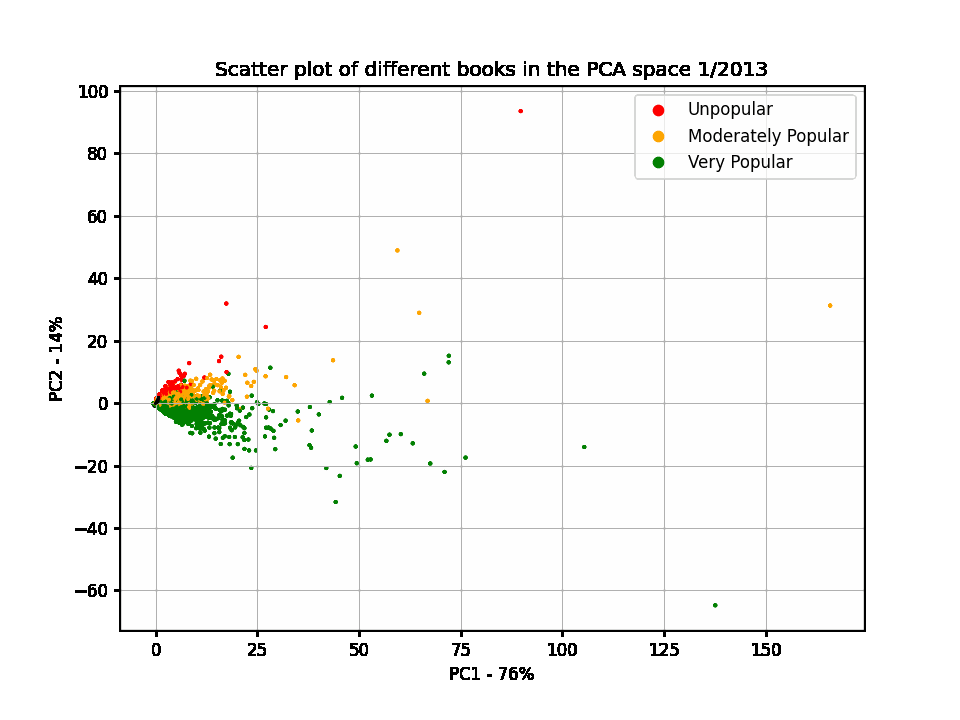

In [23]:
def buildScoreMatrix(bookReviewYearly, year, month):
    asins = list(bookReviewYearly[year][month].keys())
    ratings = np.array(list(bookReviewYearly[year][month].values()))
    return asins, ratings

plotLabels = []
bayesAvgRatinsList = []
projectedRatingsMatrixPCA = []
nbMonthlyReview = []

for m in range(1,13):
    print(f"Month {m}/{yearToStudy} : ")
    _asins, _scoreMatrix = buildScoreMatrix(bookReviewYearly, yearToStudy, m)
    _nbRating, _avgRatings = getAvgRating(_scoreMatrix)
    _confidenceNumber = np.quantile(_nbRating, BAYES_QUARTILE_OPT)
    _arithAverage = np.mean(_avgRatings)
    _bayesAvgRatings = bayesAverage(_avgRatings, _nbRating, _confidenceNumber, _arithAverage)
    _stdRatings = getRatingsStd(_scoreMatrix)
    _minRating, _maxRating = getMinMaxRating(_scoreMatrix)
    _ratingQ1, _ratingQ2, _ratingQ3 = getRatingsQuantile(_scoreMatrix)
    _top3Books, _bottom3Books, _q1BestBooksAsins = getTop3Bottom3AndQ1Books(_scoreMatrix, _bayesAvgRatings)
    
    _perStarRatingStats = pd.DataFrame(
        data=np.column_stack((_stdRatings, _minRating, _maxRating, _ratingQ1, _ratingQ2, _ratingQ3)),
        index=[f"{i} ⭐" for i in range(1, 6)],
        columns=["STD", "Min Rating Count", "Max Rating Count", "Rating Q1", "Rating Q2", "Rating Q3"]
    )
    _bayesAvgRatingPd = pd.DataFrame(
        data=np.column_stack((_nbRating, _avgRatings, _bayesAvgRatings)),
        index=_asins,
        columns=["Nb rating", "Average Rating", "Bayes Averagte Rating"]
    )

    print(f"\tPer rating star stats : ")
    display(_perStarRatingStats)
    print(f"\tTop 3 books (Bayes Avg) :")
    display(_top3Books)
    print(f"\tBottom 3 books (Bayes Avg) :")
    display(_bottom3Books)
    print(f"\tFirst Quantile of Best books (Bayes Avg) :")
    display(_q1BestBooksAsins)
    print("\tBayes average rating :")
    display(_bayesAvgRatingPd)
    _scoreMatrixPCA = np.dot(normalizeData(_scoreMatrix), projectionMatrix)
    plotLabels.append(f"{m}/{yearToStudy}")
    bayesAvgRatinsList.append(_bayesAvgRatings)
    projectedRatingsMatrixPCA.append(_scoreMatrixPCA)
    nbMonthlyReview.append(_scoreMatrix.shape[0])

def update(i):
    _x, _y, _bookClasses = plotPCAHelper(projectedRatingsMatrixPCA[i], bayesAvgRatinsList[i], plotLabels[i])
    scatter = plt.scatter(_x, _y, c=_bookClasses, cmap=colors, s=2)
    plt.legend(handles=scatter.legend_elements(num=3)[0], labels=classes)

# Plot PCA space book reviews
gifPath = "booksReviewEvolution.gif"
fig, ax = plt.subplots(figsize=(8,6), dpi=120)
plt.xlabel(f"PC1 - {math.floor(evalsVar[0])}%")
plt.ylabel(f"PC2 - {math.floor(evalsVar[1])}%")
plt.grid()
anim = animation.FuncAnimation(fig, update, frames=12, interval=25)
anim.save(gifPath, writer="pillow", fps=1)
plt.close()
Image(data=open(gifPath,'rb').read(), format='png')